# 1. Library 

In [1]:
## Parameters specific to where your folders are and your data
parameter_file = 'params/params.yaml'
import yaml
import sys

with open(parameter_file,'r') as f:
    doc = yaml.load(f)

#p = dic2obj(**doc)

data_folder = doc['data_folder']
tissues = doc['tissues'].split(',')
sys.path.append(doc['pipeline_path'])
ref_fa = doc['ref_fa']
anno_gff=doc['annotation']
mRNA_peak_file = doc["mRNA_peak_file"]

tss_annotation = doc['tss_annotation']


import os
import sys
import pandas as pd
import matplotlib
import seaborn as sns
import pickle
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from itertools import product
import glob
import re
from matplotlib_venn import venn2
from matplotlib import rcParams
import inspect
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sys.setrecursionlimit(3000)
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 8, 6
import tqdm

from os.path import basename
##mpl.use('Agg')
#mpl.style.use('ggplot')
#mpl.style.use('fivethirtyeight')
from Homer import *
import plot_tss_results
print('Number of tissues: ',len(tissues))

from scipy.stats import zscore
from scipy.stats import iqr

('Number of tissues: ', 13)


In [2]:
save_dir = "Results/Figures/Silenced_CHO"
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

# 2. Load and Preprocessing

## Read in expression matrix

In [3]:
tissues_expr = pd.read_csv("Results/merged/tissues.merge.peaksexpression.log10",sep="\t",index_col=0)
tissues_expr.head()

,Heart,Spleen,MiscOrgans,FemaleReproductive,CHO,BMDM1hKLA,Brain,Lung,Liver,BMDMwt,Muscle,Kidney,Pancreas
0,0.213256,0.000000,0.191009,0.177054,1.379905,1.93044,0.192445,0.292457,0.000000,0.000000,0.192803,0.289548,0.000000
1,0.000000,0.569562,0.658306,0.704879,0.000000,0.00000,0.365353,0.875756,0.211156,0.000000,0.160073,0.206016,0.000000
2,0.000000,0.272654,0.191009,0.650337,1.269450,0.00000,0.285237,0.440272,0.000000,0.823474,0.252575,0.377071,0.299942
3,0.213256,0.583265,0.592983,0.556972,0.347363,0.00000,0.633209,0.256951,0.000000,0.537819,0.300486,0.216445,0.380588
4,0.858835,1.743575,1.998797,1.218955,0.698374,0.00000,1.707621,0.729080,0.945703,0.642465,1.198361,0.838893,1.141651


### Read in promoter output

In [4]:
tss_meta = pd.read_csv("Results/output/TSS1.exp.meta",sep="\t",index_col=0)
tss_meta["Name"] = tss_meta.index
tss_meta.set_index("ID",inplace=True)
tss_meta.head()

,Tissues,cs,CHO ATAC Region,Gene,Gene ID,Transcript,Is Experimental,Name
ID,,,,,,,,
348823,"Spleen,MiscOrgans,FemaleReproductive,Brain,Lun...",0b11,NaN,Bmp4,NaN,XM_027386529.1,1.0,p1@Bmp4_XM_027386529.1
90264,"Spleen,MiscOrgans,FemaleReproductive,Brain,Lun...",0b00,NaN,Bmp4,NaN,XM_027386529.1,1.0,p2@Bmp4_XM_027386529.1
181215,"Spleen,MiscOrgans,FemaleReproductive,Brain,Lun...",0b00,NaN,Bmp4,NaN,XM_027386529.1,1.0,p3@Bmp4_XM_027386529.1
308710,"Heart,Spleen,MiscOrgans,FemaleReproductive,Bra...",0b11,NaN,Bmp4,NaN,XM_027386528.1,1.0,p1@Bmp4_XM_027386528.1
237253,"BMDMwt,Spleen,MiscOrgans,FemaleReproductive,CH...",0b11,NaN,Cdkn3,NaN,XM_027386531.1,1.0,p1@Cdkn3_XM_027386531.1


## Extract promoter peaks

In [5]:
prom_tissue = tissues_expr.loc[tissues_expr.index.isin(tss_meta.index)]
prom_tissue.head()

,Heart,Spleen,MiscOrgans,FemaleReproductive,CHO,BMDM1hKLA,Brain,Lung,Liver,BMDMwt,Muscle,Kidney,Pancreas
4,0.858835,1.743575,1.998797,1.218955,0.698374,0.000000,1.707621,0.729080,0.945703,0.642465,1.198361,0.838893,1.141651
5,0.401729,1.308001,1.395354,0.648333,0.000000,0.000000,0.934077,0.962747,0.864244,0.328380,1.110788,0.902202,1.001847
6,0.815153,0.519195,1.187007,0.253253,0.418561,0.000000,0.285242,0.256951,1.480135,0.561101,0.964390,0.899657,0.826164
8,0.700905,0.681902,0.877857,0.600699,0.213637,0.849419,0.858705,0.749040,0.442105,1.089905,0.633441,0.483976,0.623310
12,0.000000,0.128118,0.000000,0.000000,0.000000,0.000000,0.000000,0.241971,0.774026,0.000000,0.151598,0.000000,0.000000


## Create median and max values


## Take the max transcript for the Gene (sum across tissues)
(Also should test the median)

In [6]:
tss_meta["Median"] = prom_tissue.median(axis=1)
tss_meta["Max"] = prom_tissue.max(axis=1)
tss_meta.head()

,Tissues,cs,CHO ATAC Region,Gene,Gene ID,Transcript,Is Experimental,Name,Median,Max
ID,,,,,,,,,,
348823,"Spleen,MiscOrgans,FemaleReproductive,Brain,Lun...",0b11,NaN,Bmp4,NaN,XM_027386529.1,1.0,p1@Bmp4_XM_027386529.1,0.260824,0.949261
90264,"Spleen,MiscOrgans,FemaleReproductive,Brain,Lun...",0b00,NaN,Bmp4,NaN,XM_027386529.1,1.0,p2@Bmp4_XM_027386529.1,0.000000,0.253253
181215,"Spleen,MiscOrgans,FemaleReproductive,Brain,Lun...",0b00,NaN,Bmp4,NaN,XM_027386529.1,1.0,p3@Bmp4_XM_027386529.1,0.000000,0.193642
308710,"Heart,Spleen,MiscOrgans,FemaleReproductive,Bra...",0b11,NaN,Bmp4,NaN,XM_027386528.1,1.0,p1@Bmp4_XM_027386528.1,1.045548,2.262918
237253,"BMDMwt,Spleen,MiscOrgans,FemaleReproductive,CH...",0b11,NaN,Cdkn3,NaN,XM_027386531.1,1.0,p1@Cdkn3_XM_027386531.1,0.207487,0.658520


In [7]:
gene_tissue = pd.DataFrame(index=tss_meta["Gene"].unique(), columns=prom_tissue.columns, dtype=float)
for ind, val in tqdm.tqdm_notebook(tss_meta.groupby("Gene")):
    gene_tissue.loc[ind] = prom_tissue.loc[prom_tissue.loc[val.index].sum(axis=1).idxmax()]
    
    
gene_tissue

Widget Javascript not detected.  It may not be installed or enabled properly.


,Heart,Spleen,MiscOrgans,FemaleReproductive,CHO,BMDM1hKLA,Brain,Lung,Liver,BMDMwt,Muscle,Kidney,Pancreas
Bmp4,1.741928,1.221935,0.754393,1.058231,0.000000,0.000000,0.529344,2.262918,1.045548,0.365488,1.046018,1.435781,1.002376
Cdkn3,0.000000,0.430767,0.467970,0.395136,0.658520,0.000000,0.315934,0.166104,0.000000,0.583199,0.207487,0.000000,0.000000
Cnih1,1.026731,1.081789,0.687066,1.082934,0.305526,0.841359,1.085044,1.181446,0.662153,1.309630,0.981329,0.851393,0.330433
Cgrrf1,0.702417,1.216486,1.273049,0.666219,1.633526,1.575188,1.293760,1.121732,1.614773,1.596597,1.391258,1.156580,0.787865
Samd4a,0.339714,0.651102,0.826606,0.546711,0.749829,0.000000,0.458553,0.755641,0.231827,0.000000,0.829673,0.621120,0.357165
Gch1,0.319245,0.594936,0.694496,0.325639,0.906732,0.888179,0.580197,0.602863,1.034088,0.678518,0.677054,0.891741,0.380588
Wdhd1,0.000000,0.615134,0.829673,0.450184,1.609751,0.729165,0.615682,0.484933,0.000000,1.049218,0.000000,0.400793,0.299942
Socs4,1.013885,1.024802,0.766068,0.881669,1.480592,0.975432,0.997629,1.224510,0.771724,1.123852,0.812397,1.069384,0.832638
Mapk1ip1l,0.633421,0.887599,0.692100,0.486101,0.266488,1.691081,1.031181,0.934486,0.608640,1.466868,0.792796,0.734810,0.543688
Lgals3,0.904867,1.657064,2.061943,1.564632,0.504775,2.277838,1.086399,1.174804,1.112966,2.470116,1.548657,1.231433,0.708320


# 3. Filter to genes of interest: DNA repair genes

In [8]:
with open("../supplemental/dna_repair_genes/03_DNA_repair_genes.hamster.final.txt","r") as f:
    repair_genes = [line.rstrip() for line in f]
    
#repair_genes = list(map(lambda x: x.upper(),repair_genes))
repair_genes

['Abl1',
 'Abr',
 'Actr8',
 'Alkbh2',
 'Alkbh3',
 'Anapc1',
 'Anapc10',
 'Anapc11',
 'Anapc13',
 'Anapc2',
 'Anapc4',
 'Anapc5',
 'Anapc5',
 'Anapc7',
 'Apex1',
 'Apex2',
 'Aplf',
 'Aptx',
 'Asf1a',
 'Asf1b',
 'Atad5',
 'Atm',
 'Atr',
 'Atrip',
 'Atrx',
 'Atxn3',
 'Bcr',
 'Blm',
 'Brca1',
 'Brca2',
 'Brip1',
 'Brip1',
 'Brsk1',
 'Brsk2',
 'Bub1',
 'Bub1b',
 'Bub3',
 'Camkk1',
 'Camkk2',
 'Ccna1',
 'Ccna2',
 'Ccnb1',
 'Ccnb2',
 'Ccnb3',
 'Ccnd1',
 'Ccnd2',
 'Ccnd3',
 'Ccne1',
 'Ccne2',
 'Ccnh',
 'Ccnk',
 'Ccno',
 'Ccnt1',
 'Ccnt2',
 'Ccs',
 'Cdc14a',
 'Cdc14b',
 'Cdc16',
 'Cdc20',
 'Cdc20b',
 'Cdc23',
 'Cdc25a',
 'Cdc25b',
 'Cdc25c',
 'Cdc26',
 'Cdc27',
 'Cdc45',
 'Cdc6',
 'Cdc7',
 'Cdc73',
 'Cdk1',
 'Cdk2',
 'Cdk4',
 'Cdk7',
 'Cdkn1a',
 'Cdkn1b',
 'Cdkn2c',
 'Cetn2',
 'Chaf1a',
 'Chaf1b',
 'Chek1',
 'Chek2',
 'Chmp6',
 'Chtf18',
 'Clk2',
 'Clspn',
 'Crebbp',
 'Cry1',
 'Cry2',
 'Csnk2b',
 'Cstf2',
 'Cstf2t',
 'Cul1',
 'Cul3',
 'Dbf4',
 'Dclre1a',
 'Dclre1b',
 'Dclre1c',
 'Ddb1',
 'Ddb2'

In [9]:
tss_meta_dna_repair = tss_meta[tss_meta["Gene"].isin(repair_genes)]["Gene"].unique()

print("Number of repair genes in annotation", len(tss_meta[tss_meta["Gene"].isin(repair_genes)]["Gene"].unique()))
print("Number of overall repair genes", len(np.unique(np.array(repair_genes))))

not_found_in_anno = []
for i in repair_genes:
    if i not in tss_meta["Gene"].values:
        not_found_in_anno.append(i)

print("Number of repair genes not found in annotation", len(not_found_in_anno))


('Number of repair genes in annotation', 345)
('Number of overall repair genes', 390)
('Number of repair genes not found in annotation', 45)


In [61]:
with open(os.path.join(save_dir,"repair_genes_not_in_annotation.txt"),"w") as f:
          f.write("\n".join(not_found_in_anno))

In [10]:
gene_tissue = gene_tissue[gene_tissue.index.isin(repair_genes)]

# 4. Extract silenced Genes

## Calculate Z-score over tissues

In [11]:
gene_tissue_z = gene_tissue.apply(zscore,axis=1,result_type='broadcast') #gene_tissue.apply(lambda x) zscore(gene_tissue, axis=1)
gene_tissue_z.sum(axis=1)

Wdhd1      1.776357e-15
Parp2      2.220446e-16
Apex1      6.661338e-15
Rev1      -6.661338e-16
Anapc4    -6.661338e-15
Rnf4       5.329071e-15
Uvssa     -2.220446e-16
Ywhah     -2.886580e-15
Supt3h     5.329071e-15
Cdc16      3.774758e-15
Tfdp1      2.220446e-16
Lig4       1.110223e-14
Fancl     -6.661338e-16
Hus1       6.661338e-16
Polm      -1.998401e-15
Helq      -2.664535e-15
Gtf2h4     1.887379e-15
Mdc1      -2.220446e-16
Msh5      -4.996004e-15
Csnk2b    -5.107026e-15
Prrc2a    -8.992806e-15
Fance      1.110223e-16
Zmiz1      6.661338e-16
Ccnd3     -7.327472e-15
Ubr2       4.440892e-16
Ppp2r5d   -1.332268e-15
Mrpl2      4.884981e-15
Polh      -1.332268e-15
Pbrm1      1.901257e-15
Actr8     -2.220446e-16
               ...     
Xpc       -3.108624e-15
Rad18     -5.512951e-15
Ogg1      -2.442491e-15
Fancd2    -1.554312e-15
Mbd4      -3.885781e-15
Rmnd5a    -2.220446e-15
Cdkn1b     6.661338e-16
Recql     -3.608225e-16
Mad2l1    -1.748601e-15
Ccne1     -2.220446e-16
Tgfb1     -2.220

## A. See CHO Genes 2SD below mean 

In [12]:
silenced_cho_2sd = gene_tissue_z[gene_tissue_z["CHO"] < -2]
silenced_cho_2sd

,Heart,Spleen,MiscOrgans,FemaleReproductive,CHO,BMDM1hKLA,Brain,Lung,Liver,BMDMwt,Muscle,Kidney,Pancreas
Prrc2a,0.142615,0.809610,-0.067562,-0.160047,-2.543412,1.036469,0.621093,-0.245030,-0.467734,1.651365,0.619398,-0.691651,-0.705115
Aptx,-1.165640,0.799105,0.527244,0.567990,-2.080754,0.271866,0.928740,-0.460283,-0.090155,0.825900,1.183193,0.341302,-1.648508
Pomp,-0.328886,1.169433,1.140963,0.087856,-2.190493,-0.893668,1.325398,-0.973606,0.527874,-0.537980,0.942431,0.323999,-0.593319
Gtf2h3,-0.521364,0.764295,0.808280,0.755724,-2.669438,0.282959,0.355763,-0.819969,0.245485,-0.975494,1.344220,0.257708,0.171829
Mcm7,0.576105,-0.104511,-0.192918,0.377744,-2.361452,0.657590,0.238287,0.254940,-0.619519,1.796228,0.657849,0.221215,-1.501558
Pcna,-0.860434,1.270653,0.329114,0.206598,-2.585405,0.475329,0.500616,-0.582229,0.808077,0.790118,0.896277,-0.365513,-0.883202
Alkbh3,-0.639802,1.122544,0.943527,-0.633188,-2.116548,-0.807402,1.158290,0.258076,-0.502706,-0.802950,0.888245,-0.199689,1.331604
Ddb2,-0.849821,0.905645,0.691191,-0.451245,-2.223172,-0.893424,0.005333,0.250062,0.648682,0.942372,0.265196,1.647327,-0.938145
Ywhab,0.632674,0.454766,0.453910,0.419403,-2.516078,0.245032,1.728964,0.028546,-1.295634,0.664350,0.162691,-0.538350,-0.440275
Rpa1,0.355682,1.529676,0.690457,-0.253755,-2.187229,-0.870390,0.886749,-0.926909,-0.513564,1.143749,0.829863,-0.736305,0.051974


## Get CHO less than 1 TPM

In [13]:
pseudocount = 1 # This is b/c 1 was added to TPM in log when taking the average
silenced_cho_1tpm = gene_tissue.loc[gene_tissue["CHO"] < np.log10(1+pseudocount)].index
print("Number of CHO genes less than 1TPM:", len(silenced_cho_1tpm))
silenced_cho_1tpm

('Number of CHO genes less than 1TPM:', 72)


Index([u'Parp2', u'Ywhah', u'Cdc16', u'Tfdp1', u'Hus1', u'Mdc1', u'Pbrm1',
       u'Cul1', u'Neil2', u'Rnaseh2b', u'Wee2', u'Timeless', u'Mcm3', u'Clk2',
       u'Bcr', u'Mcm3ap', u'Cdkn1a', u'Ccna1', u'Dna2', u'Msh4', u'Polb',
       u'Smad2', u'Pias2', u'Rbbp4', u'Hdac1', u'E2f2', u'Ccno', u'Rbbp8',
       u'Rad23a', u'Dnaja2', u'Brsk2', u'Mgmt', u'Cdc14b', u'Rmi1', u'Gadd45g',
       u'Mcm5', u'Ttk', u'Gsk3b', u'Gtf2h3', u'Rad9b', u'Anapc13', u'Rad54l2',
       u'Mlh1', u'Dnaja4', u'Mcm7', u'Chaf1b', u'Xab2', u'Chek2', u'Smg7',
       u'Tmem30b', u'Tgfb3', u'Ppp2r5a', u'Tgfb2', u'Pias4', u'Pold1',
       u'Tp53bp1', u'Ddb2', u'Ube2v1', u'Ywhab', u'Eme1', u'Ercc4', u'Chmp6',
       u'Prkd3', u'Camkk1', u'Tp53', u'Dhx58', u'Ccne1', u'Tgfb1', u'Brsk1',
       u'Ercc2', u'Ercc1', u'Prkd2'],
      dtype='object')

## B and C. More than 75% /100% of the other tissues are on

In [14]:
n_samples = len(gene_tissue.columns)-1 # Remove CHO
cutoffs = dict()
gene_tissue_silenced = gene_tissue.drop(["CHO"],axis=1) < np.log10(1+pseudocount)

num_tissues_silenced = gene_tissue_silenced.sum(axis=1)
cutoffs[75] = num_tissues_silenced[num_tissues_silenced < (1-0.75)*n_samples].index
cutoffs[90] = num_tissues_silenced[num_tissues_silenced < (1-0.9)*n_samples].index

cutoffs[100] = num_tissues_silenced[num_tissues_silenced ==0].index




cho_75 = set(silenced_cho_1tpm).intersection(cutoffs[75])
cho_90 = set(silenced_cho_1tpm).intersection(cutoffs[90])
cho_100 = set(silenced_cho_1tpm).intersection(cutoffs[100])

print("75th percentile number of silenced genes:", len(cho_75))
print("90th percentile number of silenced genes:", len(cho_90))
print("100th percentile number of silenced genes:", len(cho_100))

('75th percentile number of silenced genes:', 24)
('90th percentile number of silenced genes:', 17)
('100th percentile number of silenced genes:', 8)


## D. CHO IQR outlier 

In [15]:
gene_iqr = iqr(gene_tissue,axis=1)
lower_quart = np.percentile(gene_tissue,25,axis=1)
iqr_outlier_thresh = lower_quart - gene_iqr*1.5

silenced_cho_1tpm_iqr_outlier = gene_tissue[gene_tissue["CHO"] < iqr_outlier_thresh].index
print("Number of genes: ", len(silenced_cho_1tpm_iqr_outlier))
silenced_cho_1tpm_iqr_outlier

('Number of genes: ', 12)


Index([u'Cdc16', u'Prrc2a', u'Rad1', u'Gtf2h3', u'Mcm7', u'Ywhab', u'Per1',
       u'Skp1', u'Mad2l1', u'Rrm2b', u'Ywhaz', u'Rbbp7'],
      dtype='object')

In [18]:
outlier_methods_df = pd.DataFrame(
    index=["Genes", "Number of Genes"],
    columns=[
        "IQR", "1TPM", "1TPM and 75 percent tissues on",
        "1TPM and 90 percent tissues on", "1TPM and 100 percent tissues on",
        "Zscore -2"
    ])

outlier_methods_df.loc["Number of Genes"] = [
    len(silenced_cho_1tpm_iqr_outlier),
    len(silenced_cho_1tpm),
    len(cho_75),
    len(cho_90),
    len(cho_100), 
    len(silenced_cho_2sd)
]
outlier_methods_df.loc["Genes"] = [
    set(silenced_cho_1tpm_iqr_outlier),
    set(silenced_cho_1tpm), cho_75, cho_90, cho_100, set(silenced_cho_2sd.index.values)
]
outlier_methods_df

,IQR,1TPM,1TPM and 75 percent tissues on,1TPM and 90 percent tissues on,1TPM and 100 percent tissues on,Zscore -2
Genes,"{Ywhaz, Mad2l1, Cdc16, Skp1, Gtf2h3, Prrc2a, R...","{Rbbp8, Brsk2, Prkd3, Mdc1, Msh4, Rbbp4, Pias2...","{Rbbp4, Mcm7, Anapc13, Pias4, Pbrm1, Hdac1, Sm...","{Hdac1, Smg7, Cdc16, Gtf2h3, Cdkn1a, Ppp2r5a, ...","{Hdac1, Smg7, Gtf2h3, Rbbp4, Ywhab, Pias4, Ddb...","{Pcna, Ywhaz, Mad2l1, Pomp, Gtf2h3, Rbbp7, Prr..."
Number of Genes,12,72,24,17,8,15


# 5. Plot silenced genes values

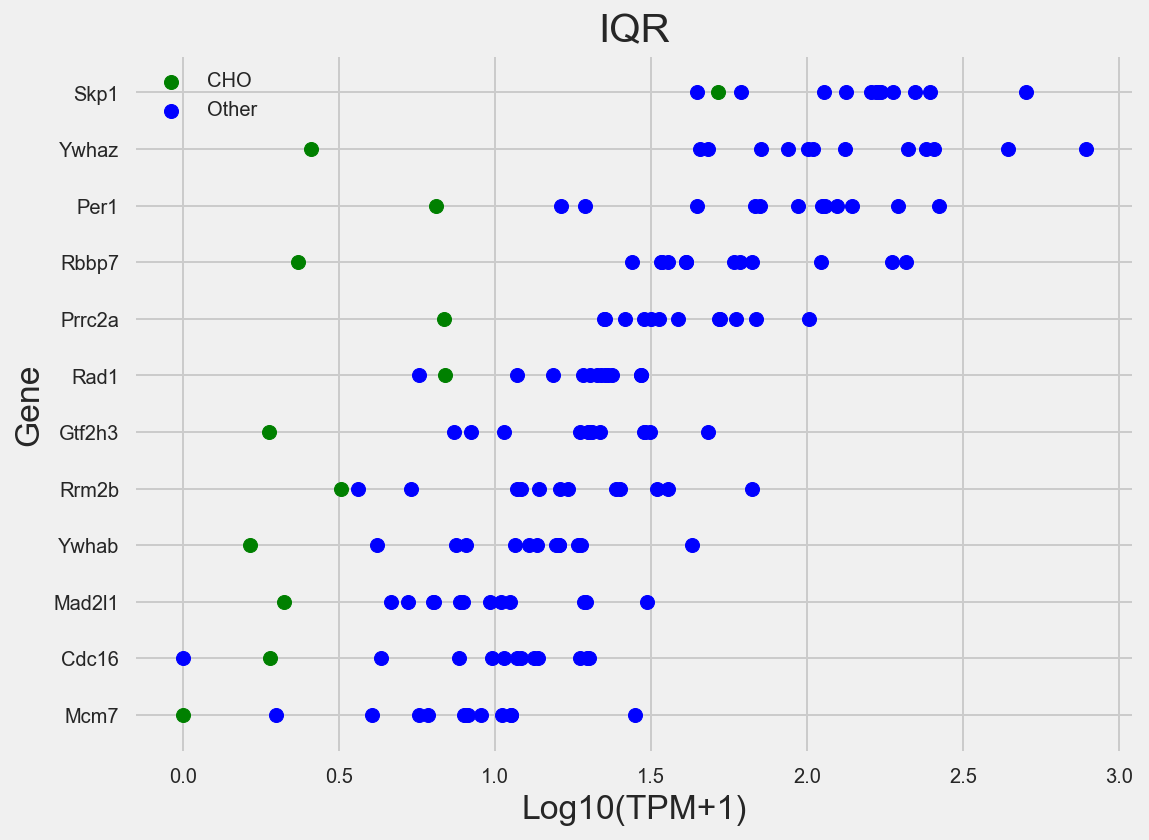

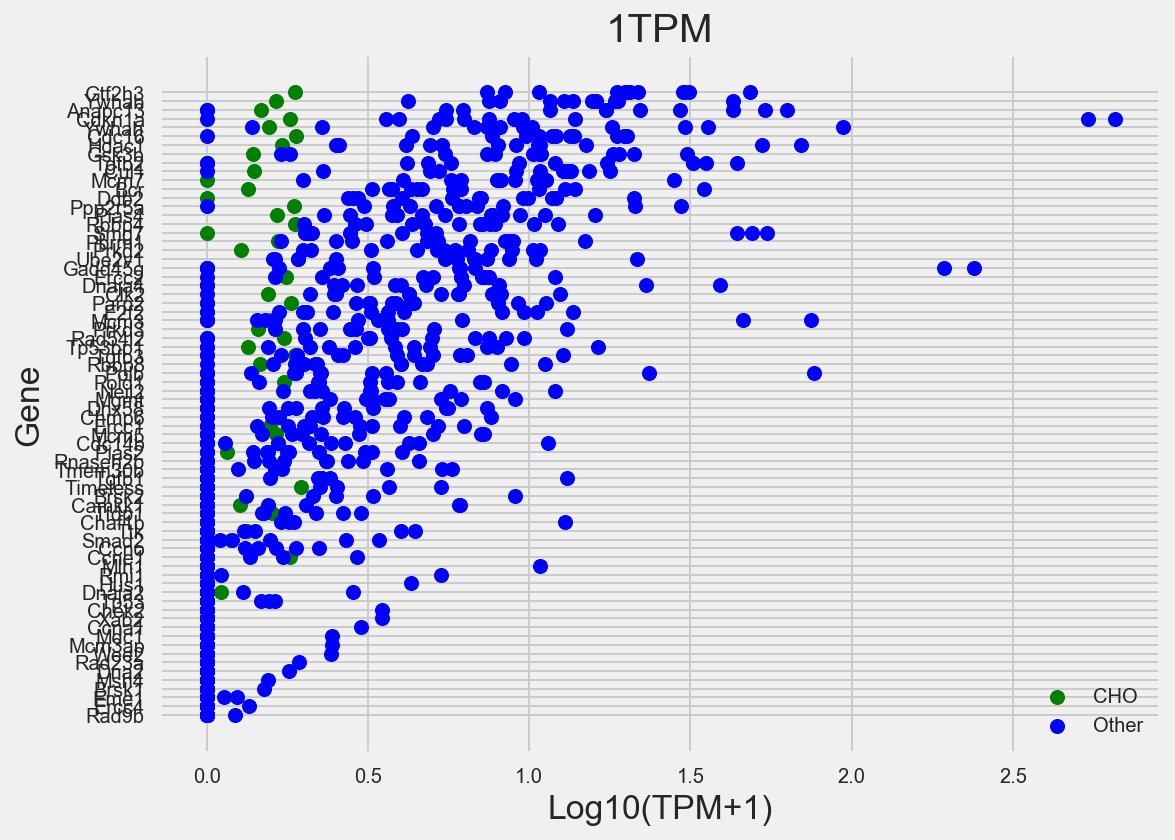

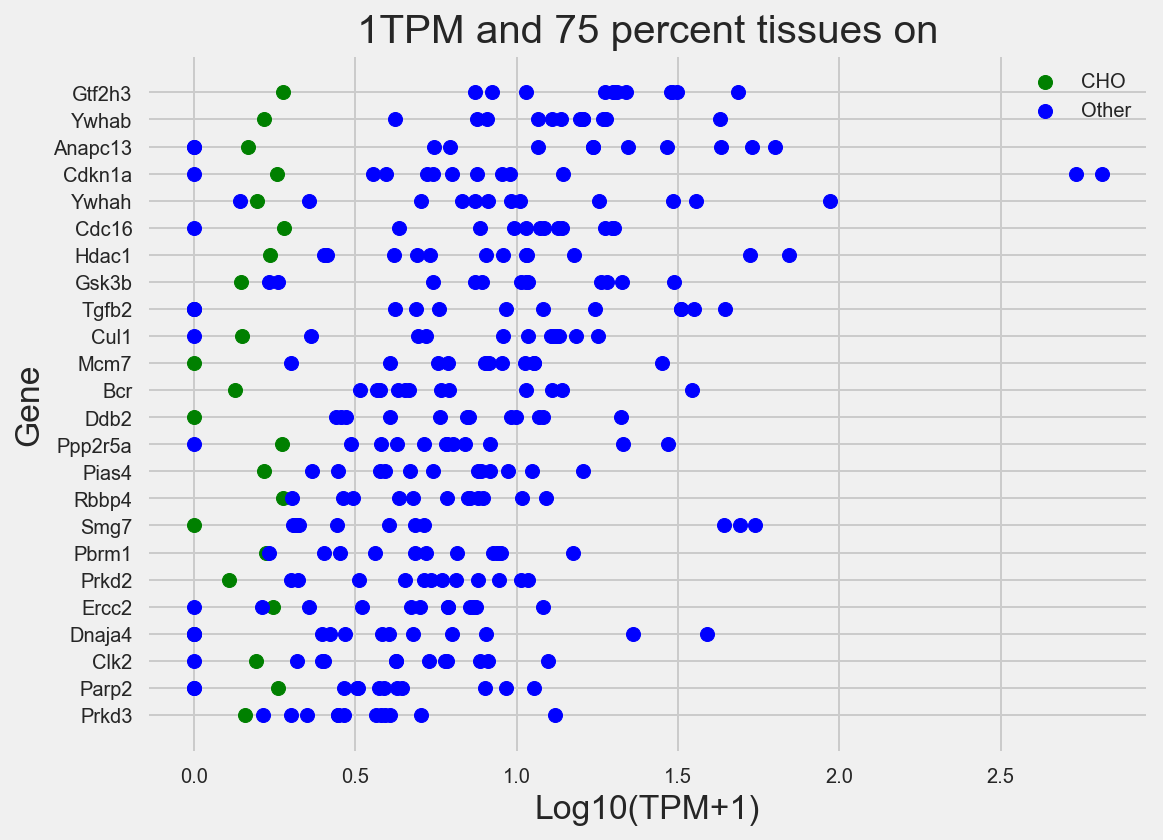

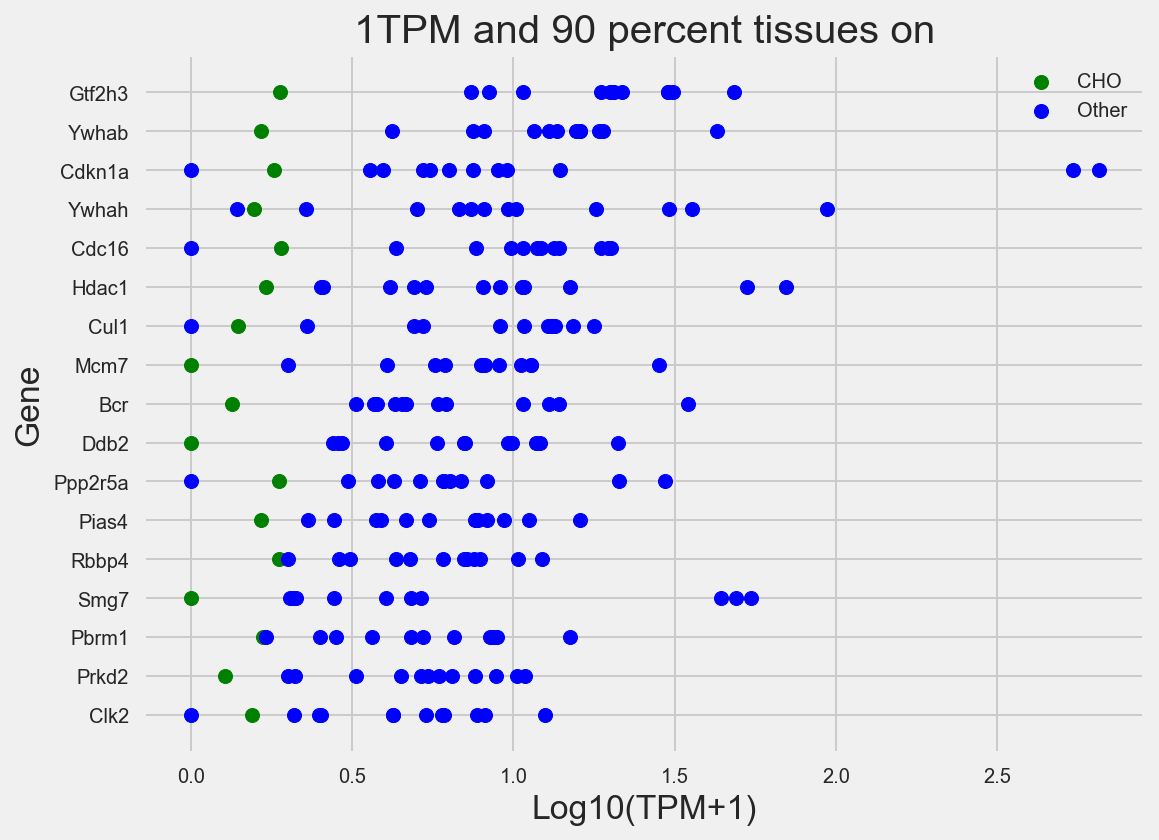

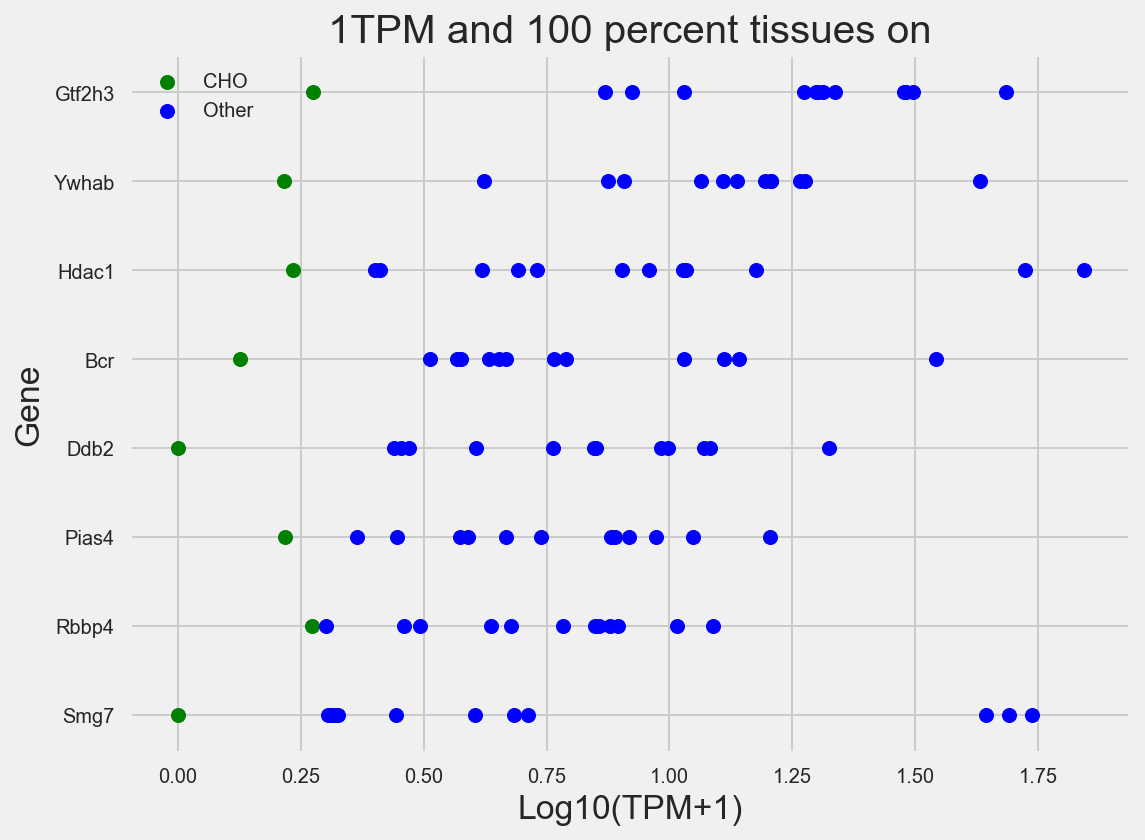

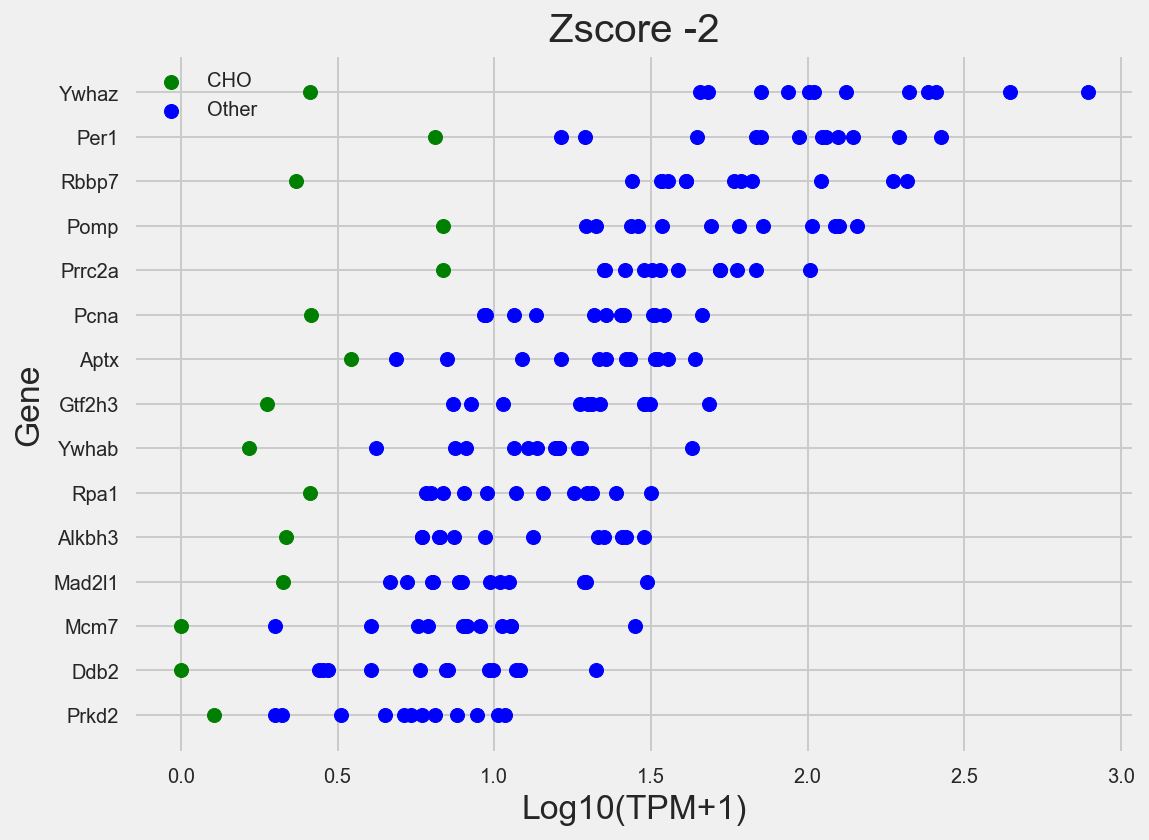

In [62]:
for col in outlier_methods_df.columns.values:
    curr_order = gene_tissue.loc[outlier_methods_df.loc["Genes",col]].apply(lambda x: x.sum(), axis=1).sort_values().index
    curr_genes = gene_tissue.loc[curr_order]
    zip(range(len(curr_genes)), curr_genes.index)

    # Construct scatter values
    cho_scatter_x = []
    cho_scatter_y = []
    tissue_scatter_x = []
    tissue_scatter_y = []
    n_tissues = curr_genes.shape[1] - 1
    for i in zip(range(len(curr_genes)), curr_genes.index):
        cho_scatter_y.append(i[0])
        cho_scatter_x.append(gene_tissue.loc[i[1],"CHO"])
        tissue_scatter_y += [i[0]] * n_tissues
        tissue_scatter_x += list(gene_tissue.drop("CHO",axis=1).loc[i[1]].values)


    f, ax = plt.subplots()
    ax.scatter(cho_scatter_x,cho_scatter_y,color="g")
    ax.scatter(tissue_scatter_x,tissue_scatter_y)
    plt.ylabel("Gene")
    plt.xlabel("Log10(TPM+1)")
    ax.set_yticks(range(len(cho_scatter_y)))
    ax.set_yticklabels(curr_genes.index.values);
    plt.title(col);
    plt.legend(["CHO","Other"])
    name =os.path.join(save_dir,"repair_genes_method_" + col.replace(" ",""))
    plt.savefig(name+".png")
    #gene_tissue.loc[]
    curr_genes.to_csv(name + ".txt")
#     with open(name+".txt","w") as f:
        
#         f.write("\n".join(list(curr_genes.index.values)))

# 6. Calculate TPM ratio

In [67]:
10**curr_genes

,Heart,Spleen,MiscOrgans,FemaleReproductive,CHO,BMDM1hKLA,Brain,Lung,Liver,BMDMwt,Muscle,Kidney,Pancreas
Mcm7,10.584139,6.127006,5.707040,9.025364,1.000000,11.30,8.069014,8.177659,4.051420,28.20,11.302345,7.959125,1.994994
Ppp2r5a,29.479484,6.079474,8.277318,6.889884,1.872920,1.00,5.140518,4.268052,3.793942,3.07,21.297887,6.350229,6.049314
Pias4,2.313007,16.032467,11.172735,3.754997,1.649195,3.90,9.368102,4.661570,2.788181,7.60,5.487750,7.747074,8.254998
Pbrm1,14.931175,8.437897,2.521904,8.675828,1.670278,6.54,8.917432,5.228125,1.705404,8.73,2.821347,3.633476,4.822147
Parp2,3.745210,4.393746,11.289951,3.214032,1.820564,1.00,9.246213,3.872949,2.906557,7.98,4.258720,3.195044,1.000000


## Log2

/home/isshamie/software/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:47: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Mcm7       2.964306
Ppp2r5a    1.677451
Pias4      1.851232
Pbrm1      1.693610
Parp2      1.026123
dtype: float64
            Heart    Spleen  MiscOrgans  FemaleReproductive       CHO  \
Parp2    1.905047  2.135451    3.496967            1.684384  0.864386   
Pbrm1    3.900256  3.076883    1.334513            3.117002  0.740088   
Pias4    1.209769  4.002925    3.481910            1.908812  0.721762   
Ppp2r5a  4.881639  2.603946    3.049163            2.784480  0.905289   
Mcm7     3.403832  2.615182    2.512743            3.173985  0.000000   

         BMDM1hKLA     Brain      Lung     Liver    BMDMwt    Muscle  \
Parp2     0.000000  3.208863  1.953432  1.539311  2.996389  2.090420   
Pbrm1     2.709291  3.156628  2.386294  0.770113  3.125982  1.496384   
Pias4     1.963474  3.227757  2.220816  1.479324  2.925999  2.456215   
Ppp2r5a   0.000000  2.361914  2.093578  1.923698  1.618239  4.412638   
Mcm7      3.498251  3.012392  3.031688  2.018427  4.817623  3.498550   

           Ki

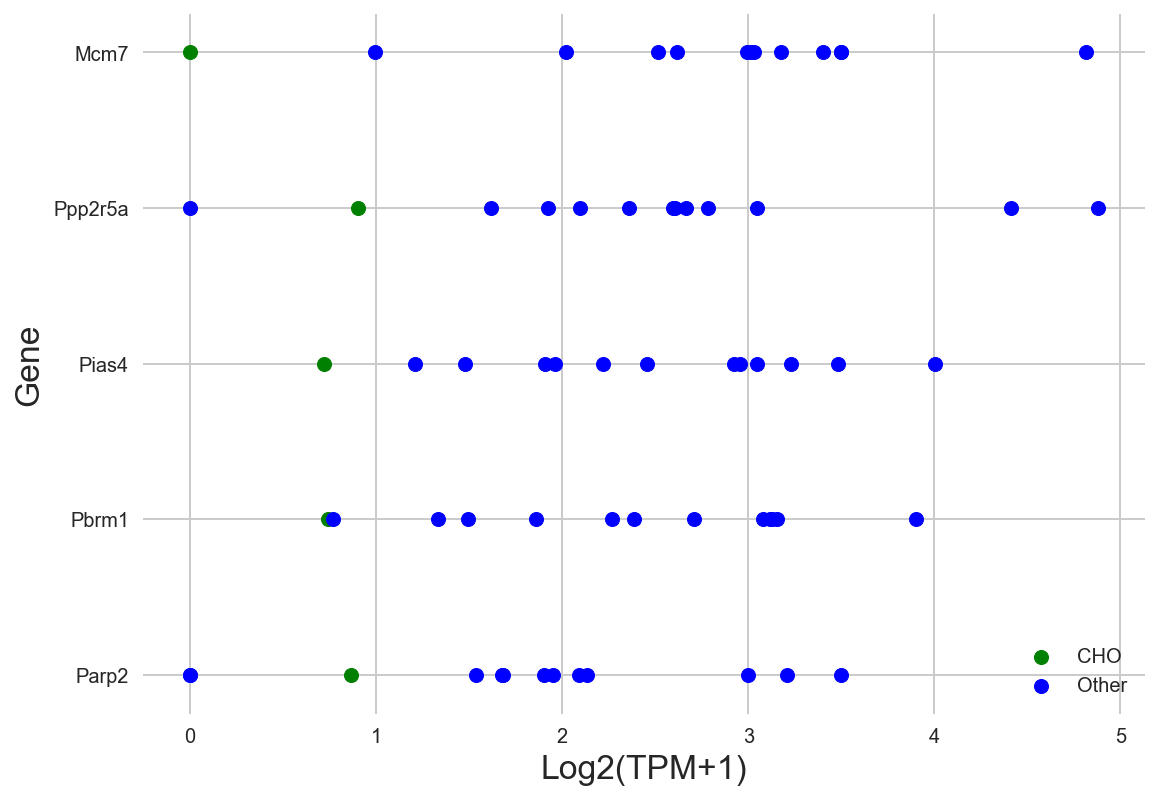

In [81]:
repair_genes = ["Mcm7",
                "Ppp2r5a",
                "Pias4",
                "Pbrm1",
                "Parp2"]

curr_genes = gene_tissue.loc[repair_genes]
# Go into log2
curr_genes = np.log2(10**curr_genes)
gene_tpm_ratio = (curr_genes.drop("CHO",axis=1).mean(axis=1) - curr_genes["CHO"])
gene_tpm_ratio


curr_order = curr_genes.apply(lambda x: x.sum(), axis=1).sort_values().index
curr_genes = curr_genes.loc[curr_order]
zip(range(len(curr_genes)), curr_genes.index)

# Construct scatter values
cho_scatter_x = []
cho_scatter_y = []
tissue_scatter_x = []
tissue_scatter_y = []
n_tissues = curr_genes.shape[1] - 1
for i in zip(range(len(curr_genes)), curr_genes.index):
    cho_scatter_y.append(i[0])
    cho_scatter_x.append(curr_genes.loc[i[1],"CHO"])
    tissue_scatter_y += [i[0]] * n_tissues
    tissue_scatter_x += list(curr_genes.drop("CHO",axis=1).loc[i[1]].values)


f, ax = plt.subplots()
ax.scatter(cho_scatter_x,cho_scatter_y,color="g")
ax.scatter(tissue_scatter_x,tissue_scatter_y)
plt.ylabel("Gene")
plt.xlabel("Log2(TPM+1)")
ax.set_yticks(range(len(cho_scatter_y)))
ax.set_yticklabels(curr_genes.index.values);

plt.legend(["CHO","Other"])
name = os.path.join(save_dir,"repair_genes")


# Save
helper_save(name+"_log2")
# plt.savefig(name+"_log2.png")
# plt.savefig(name+"_log2.eps")
gene_tpm_ratio.to_csv(name + "_log2_ratio.txt")
print("TPM ratio", gene_tpm_ratio)
print(curr_genes)

## Log10

/home/isshamie/software/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:46: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Mcm7       0.892345
Ppp2r5a    0.504963
Pias4      0.557276
Pbrm1      0.509827
Parp2      0.308894
dtype: float64
            Heart    Spleen  MiscOrgans  FemaleReproductive       CHO  \
Parp2    0.573476  0.642835    1.052692            0.507050  0.260206   
Pbrm1    1.174094  0.926234    0.401729            0.938311  0.222789   
Pias4    0.364177  1.205000    1.048159            0.574610  0.217272   
Ppp2r5a  1.469520  0.783866    0.917890            0.838212  0.272519   
Mcm7     1.024656  0.787248    0.756411            0.955465  0.000000   

         BMDM1hKLA     Brain      Lung     Liver    BMDMwt    Muscle  \
Parp2     0.000000  0.965964  0.588042  0.463379  0.902003  0.629279   
Pbrm1     0.815578  0.950240  0.718346  0.231827  0.941014  0.450457   
Pias4     0.591065  0.971652  0.668532  0.445321  0.880814  0.739394   
Ppp2r5a   0.000000  0.711007  0.630230  0.579091  0.487138  1.328337   
Mcm7      1.053078  0.906820  0.912629  0.607607  1.450249  1.053169   

           Ki

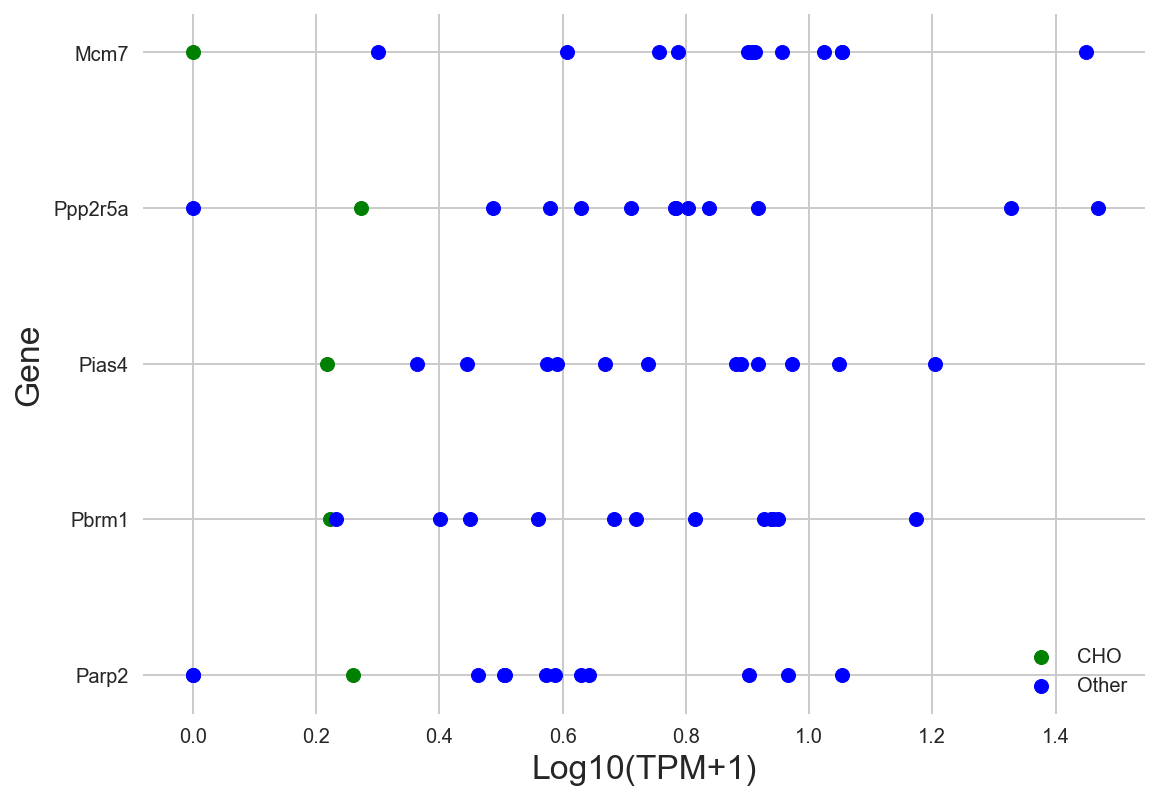

In [80]:
repair_genes = ["Mcm7",
                "Ppp2r5a",
                "Pias4",
                "Pbrm1",
                "Parp2"]

curr_genes = gene_tissue.loc[repair_genes]
# Stay in log10
gene_tpm_ratio = (curr_genes.drop("CHO",axis=1).mean(axis=1) - curr_genes["CHO"])
gene_tpm_ratio


curr_order = curr_genes.apply(lambda x: x.sum(), axis=1).sort_values().index
curr_genes = curr_genes.loc[curr_order]
zip(range(len(curr_genes)), curr_genes.index)

# Construct scatter values
cho_scatter_x = []
cho_scatter_y = []
tissue_scatter_x = []
tissue_scatter_y = []
n_tissues = curr_genes.shape[1] - 1
for i in zip(range(len(curr_genes)), curr_genes.index):
    cho_scatter_y.append(i[0])
    cho_scatter_x.append(curr_genes.loc[i[1],"CHO"])
    tissue_scatter_y += [i[0]] * n_tissues
    tissue_scatter_x += list(curr_genes.drop("CHO",axis=1).loc[i[1]].values)


f, ax = plt.subplots()
ax.scatter(cho_scatter_x,cho_scatter_y,color="g")
ax.scatter(tissue_scatter_x,tissue_scatter_y)
plt.ylabel("Gene")
plt.xlabel("Log10(TPM+1)")
ax.set_yticks(range(len(cho_scatter_y)))
ax.set_yticklabels(curr_genes.index.values);

plt.legend(["CHO","Other"])
name = os.path.join(save_dir,"repair_genes")


# Save
helper_save(name+"_log10")
# plt.savefig(name+"_log10.png")
# plt.savefig(name+"_log10.eps")
gene_tpm_ratio.to_csv(name + "_log10_ratio.txt")
print(gene_tpm_ratio)
print(curr_genes)

## Plot the two